# Univariate CNN-LSTM Neural Network for Predicting Particulate Matter (PM2.5) Concentration

## 1. Description
### 1.1 Technologies Used
* MacOS 
* Python 3.7.3
* Python Libraries : 
    * Pandas
    * Numpy
    * Matplotlib
    * TensorFlow
    * Scikit-learn
* Others:
    * Visual Studio Code
    * Jupyter Notebook

### 1.2 Dataset
* Dataset used is a real dataset from UCI Machine Learning titled “Beijing PM2.5 Data Data Set”.

## 2. Architecture of Univariate CNN-LSTM Model
* The method used is to combine Convolutional Neural Network (CNN) for feature extraction and Long Short-Term Memory (LSTM) to predict PM2.5 concentrations in the air.
* Following are the architecture of CNN-LSTM model proposed by C.-J. Huang and P.-H. Kuo, 2018 (Figure 1) and the flowchart of PM2.5 prediction system (Figure 2).

![Figure 1](img/1.png)

![Figure 2](img/2.png)

## 3. Implementation
### 3.1 Preprocessing

In [1]:
"""
Preprocessing Data
- Fill missing value
"""
import pandas as pd
import numpy as np
import math, os
from datetime import datetime

def load_data(path):
    # read all column names 
    cols = list(pd.read_csv(path, nrows =1))
    df = pd.read_csv(path, sep=',', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':['year', 'month', 'day', 'hour']}, date_parser=custom_parser, index_col=['datetime'], usecols=[i for i in cols if i != 'No'])
    # specify new column names
    df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
    return df

def export_data(df, path):
  df.to_csv(path)
  print('>>> data exported succesfully!')

def get_metadata(df):
  return {
    'row_num' : df.shape[0],
    'col_num' : df.shape[1],
    'attr' : df.columns.to_list(),
    'timeseries_start': df.index.min(),
    'timeseries_end': df.index.max(),
    'null_value': df.isnull().sum().to_dict(),
    'dtypes': df.dtypes.to_dict()
  }

# parse datetime
def custom_parser(year, month, day, hour):
    date_string = year + ' ' + month + ' ' + day + ' ' + hour
    return datetime.strptime(date_string, '%Y %m %d %H')

"""
Handle Missing Value 
"""
def custom_fill(values):
  one_day = 60 * 24
#   for row in range(values.shape[0]):
#       for col in range(values.shape[1]):
#           if np.nan(values[row, col]):
#             values[row, col] = values[row - one_day, col]
  for row in range(values.shape[0]):
    if np.isnan(values[row]):
        values[row] = values[row - one_day]

def fill_missing_value(df, method, attr=None):
    if method == 'custom':
        custom_fill(df.values)
    elif method == 'zero':
        df[attr].fillna(0, inplace=True)
    elif method == 'mean':
        try:
            if not math.isnan(df[attr].mean()):
                df[attr].fillna(df[attr].mean().round(2), inplace=True)
        except RuntimeWarning:
            pass
    elif method == 'median':
        df[attr].fillna(df[attr].median(), inplace=True)
    elif method == 'mode':
        if not df[attr].mode().empty:
            df[attr].fillna(df[attr].mode()[0], inplace=True)
    elif method == 'bfill' or method == 'ffill':
        df[attr].fillna(method=method, inplace=True)
    elif method == 'linear':
        df[attr].interpolate(method=method, limit_direction='forward', axis=0, inplace=True)
        df[attr] = df[attr].round(2)
    elif method == 'polynomial':
        try:
            df[attr].interpolate(method=method, order=2, inplace=True)
            df[attr] = df[attr].round(2)
        except FutureWarning:
            pass
    return df

def print_metadata(metadata):
    print('=====================================')
    print('[ METADATA ]')
    for key, val in metadata.items():
        print('{} => {}'.format(key, val))
    print('=====================================')

In [2]:
# define path
PATH = os.getcwd()
DATASET_DIR_PATH = PATH + '/../data/'
DATASET_PATH = {
    'raw': DATASET_DIR_PATH + 'PRSA_data.csv',
    'preprocessed': DATASET_DIR_PATH + 'PRSA_data_preprocessed.csv'
}

In [3]:
# get initial data and metadata
df = load_data(DATASET_PATH['raw'])
metadata = get_metadata(df)

df.head(5)
print_metadata(metadata)

[ METADATA ]
row_num => 43824
col_num => 8
attr => ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
timeseries_start => 2010-01-01 00:00:00
timeseries_end => 2014-12-31 23:00:00
null_value => {'pollution': 2067, 'dew': 0, 'temp': 0, 'press': 0, 'wnd_dir': 0, 'wnd_spd': 0, 'snow': 0, 'rain': 0}
dtypes => {'pollution': dtype('float64'), 'dew': dtype('int64'), 'temp': dtype('float64'), 'press': dtype('float64'), 'wnd_dir': dtype('O'), 'wnd_spd': dtype('float64'), 'snow': dtype('int64'), 'rain': dtype('int64')}


In [4]:
# ambil attr yg punya null value berdasarkan metadata
nullAttr = []
for key, val in metadata['null_value'].items():
    if val > 0:
        nullAttr.append(key)
        
# fill missing value
for attr in nullAttr:
#     df[attr] = df[attr].astype('float32')
    df = fill_missing_value(df, 'zero', attr)

# get new metadata
metadata = get_metadata(df)
print_metadata(metadata)

# custom_fill(df['pollution'].values)

[ METADATA ]
row_num => 43824
col_num => 8
attr => ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
timeseries_start => 2010-01-01 00:00:00
timeseries_end => 2014-12-31 23:00:00
null_value => {'pollution': 0, 'dew': 0, 'temp': 0, 'press': 0, 'wnd_dir': 0, 'wnd_spd': 0, 'snow': 0, 'rain': 0}
dtypes => {'pollution': dtype('float64'), 'dew': dtype('int64'), 'temp': dtype('float64'), 'press': dtype('float64'), 'wnd_dir': dtype('O'), 'wnd_spd': dtype('float64'), 'snow': dtype('int64'), 'rain': dtype('int64')}


In [6]:
# drop the first 24 hours or 1 day because the pollution table is 0
df = df[24:]
# get new metadata
metadata = get_metadata(df)
print_metadata(metadata)

[ METADATA ]
row_num => 43776
col_num => 8
attr => ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
timeseries_start => 2010-01-03 00:00:00
timeseries_end => 2014-12-31 23:00:00
null_value => {'pollution': 0, 'dew': 0, 'temp': 0, 'press': 0, 'wnd_dir': 0, 'wnd_spd': 0, 'snow': 0, 'rain': 0}
dtypes => {'pollution': dtype('float64'), 'dew': dtype('int64'), 'temp': dtype('float64'), 'press': dtype('float64'), 'wnd_dir': dtype('O'), 'wnd_spd': dtype('float64'), 'snow': dtype('int64'), 'rain': dtype('int64')}


In [7]:
# export data
export_data(df, DATASET_PATH['preprocessed'])

>>> data exported succesfully!


### 3.2 Forecasting
This is univariate, so we just use **1 feature**, that is **'pollution'** or pm2.5 concentration in the air
#### 3.2.1 Preparing

In [129]:
import os, sys, math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns 

In [130]:
# import the preprocessed data
df_process = pd.read_csv(DATASET_PATH['preprocessed'], header=0, index_col=0)

In [131]:
df_process.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
datetime,,,,,,,,
2010-01-03 00:00:00,90.0,-7,-6.0,1027.0,SE,58.56,4,0
2010-01-03 01:00:00,63.0,-8,-6.0,1026.0,SE,61.69,5,0
2010-01-03 02:00:00,65.0,-8,-7.0,1026.0,SE,65.71,6,0
2010-01-03 03:00:00,55.0,-8,-7.0,1025.0,SE,68.84,7,0
2010-01-03 04:00:00,65.0,-8,-7.0,1024.0,SE,72.86,8,0


In [132]:
# save data values as array
val = df_process['pollution'].values
print(val)
print('dimension = {}'.format(val.shape))

[90. 63. 65. ... 10.  8. 12.]
dimension = (43776,)


In [133]:
# reshape to change the dimension of data
val = np.reshape(val, (-1, 1))
print('dimension = {}'.format(val.shape))

dimension = (43776, 1)


In [134]:
# normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_val = scaler.fit_transform(val)
print(scaled_val)

[[0.09054326]
 [0.06338028]
 [0.06539235]
 ...
 [0.01006036]
 [0.00804829]
 [0.01207243]]


#### 3.2.2 Splitting

In [135]:
# determine train and test size
train_size = int(len(val) * 0.20)
test_size = len(val) - train_size
print('Train size: ', train_size)
print('Test size: ', test_size)

Train size:  8755
Test size:  35021


In [136]:
# split data into train and test
data = {
    'train': scaled_val[0:train_size,:],
    'test': scaled_val[train_size:len(scaled_val),:]
}

for key, val in data.items():
    print('{} => {}'.format(key, val))

train => [[0.09054326]
 [0.06338028]
 [0.06539235]
 ...
 [0.03722334]
 [0.04024145]
 [0.05231388]]
test => [[0.06338028]
 [0.07243461]
 [0.07645875]
 ...
 [0.01006036]
 [0.00804829]
 [0.01207243]]


In [137]:
# splitting for LSTM
def split(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# splitting CNN
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix, 0], sequence[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

#### 3.2.3 Modeling - LSTM
- LSTM dengan 100 neurons di layer pertama
- Dropout 20%
- 1 neuron di layer output untuk memprediksi Global_active_power
- Model di fit untuk training epochs = 20 dengan batch size = 70

In [138]:
# LSTM

# split data into input and output
# look the previous 30 hours as input
# X = t, Y = t+1
look_back = 30
data['train_in'], data['train_out'] = split(data['train'], look_back)
data['test_in'], data['test_out'] = split(data['test'], look_back)

In [139]:
for key, val in data.items():
    print('{} => {}'.format(key, val.shape))

train => (8755, 1)
test => (35021, 1)
train_in => (8724, 30)
train_out => (8724,)
test_in => (34990, 30)
test_out => (34990,)


In [140]:
# reshape input menjadi 3D array : [samples, time steps, features]
data['train_in'] = np.reshape(data['train_in'], (data['train_in'].shape[0], 1, data['train_in'] .shape[1]))
data['test_in']  = np.reshape(data['test_in'], (data['test_in'].shape[0], 1, data['test_in'].shape[1]))

In [141]:
# design model
model = Sequential()
model.add(LSTM(100, input_shape=(data['train_in'].shape[1], data['train_in'].shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [142]:
# train data and recorded in history
history = model.fit(data['train_in'], data['train_out'], epochs=50, batch_size=70, 
                    validation_data=(data['test_in'], data['test_out']), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

Train on 8724 samples, validate on 34990 samples
Epoch 1/50
8724/8724 [==============================] - 4s 512us/sample - loss: 0.0034 - val_loss: 0.0017
Epoch 2/50
8724/8724 [==============================] - 4s 440us/sample - loss: 0.0016 - val_loss: 0.0012
Epoch 3/50
8724/8724 [==============================] - 2s 234us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 4/50
8724/8724 [==============================] - 3s 397us/sample - loss: 0.0013 - val_loss: 8.8740e-04
Epoch 5/50
8724/8724 [==============================] - 3s 363us/sample - loss: 0.0011 - val_loss: 0.0016
Epoch 6/50
8724/8724 [==============================] - 2s 267us/sample - loss: 0.0013 - val_loss: 8.1005e-04
Epoch 7/50
8724/8724 [==============================] - 3s 355us/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 8/50
8724/8724 [==============================] - 2s 259us/sample - loss: 0.0012 - val_loss: 7.9596e-04
Epoch 9/50
8724/8724 [==============================] - 3s 293us/sample - loss: 0.0010 - va

In [143]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 100)               52400     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 52,501
Trainable params: 52,501
Non-trainable params: 0
_________________________________________________________________


In [144]:
# predicting

prediction = {
    'train_predict': model.predict(data['train_in']),
    'test_predict': model.predict(data['test_in'])
}

# invert prediksi
prediction['train_predict'] = scaler.inverse_transform(prediction['train_predict'])
data['train_out'] = scaler.inverse_transform([data['train_out']])

prediction['test_predict'] = scaler.inverse_transform(prediction['test_predict'])
data['test_out'] = scaler.inverse_transform([data['test_out']])

In [145]:
print('Train MAE:', mean_absolute_error(data['train_out'][0], prediction['train_predict'][:,0]))
print('Train RMSE:',np.sqrt(mean_squared_error(data['train_out'][0], prediction['train_predict'][:,0])))
print('Test MAE:', mean_absolute_error(data['test_out'][0], prediction['test_predict'][:,0]))
print('Test RMSE:',np.sqrt(mean_squared_error(data['test_out'][0], prediction['test_predict'][:,0])))

Train MAE: 18.12370904030322
Train RMSE: 33.04927919495141
Test MAE: 17.375310584049164
Test RMSE: 30.03008541161989


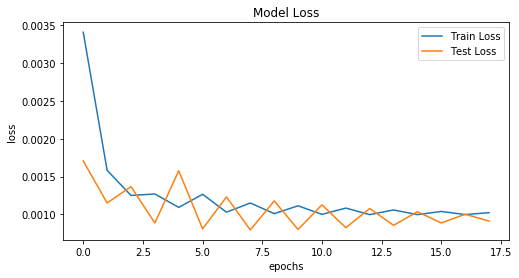

In [146]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

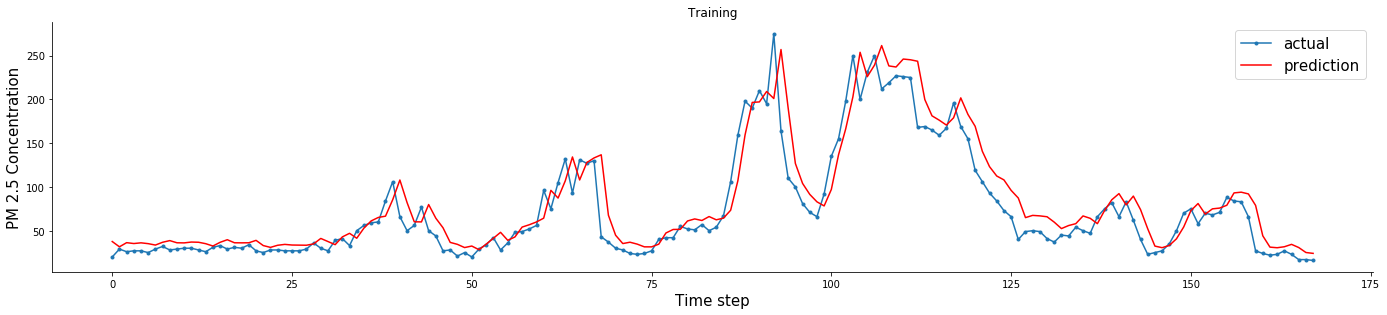

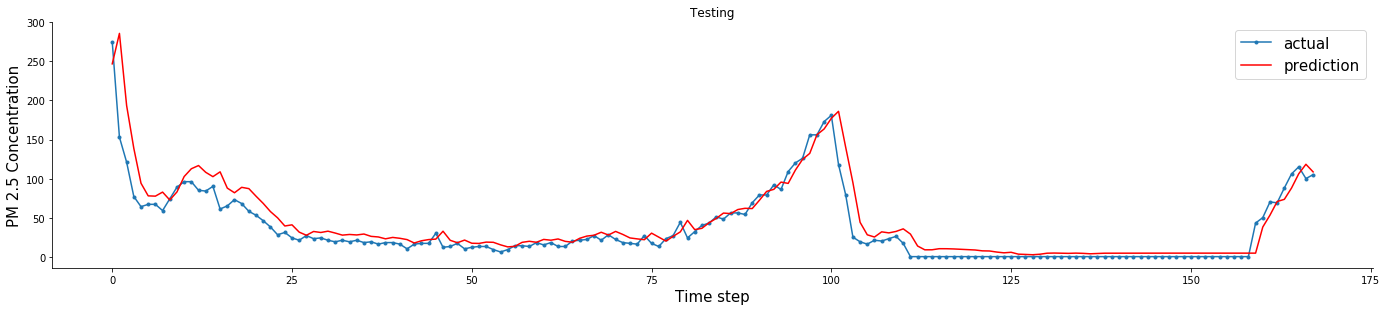

In [147]:
rng = 24*7 
aa = [x for x in range(rng)]

plt.figure(figsize=(20,4))
plt.plot(aa, data['train_out'][0][:rng], marker='.', label="actual")
plt.plot(aa, prediction['train_predict'][:,0][:rng], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Training')
plt.ylabel('PM 2.5 Concentration', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

plt.figure(figsize=(20,4))
plt.plot(aa, data['test_out'][0][:rng], marker='.', label="actual")
plt.plot(aa, prediction['test_predict'][:,0][:rng], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Testing')
plt.ylabel('PM 2.5 Concentration', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

#### 3.2.4 Modeling - CNN

In [36]:
# CNN

# split data into input and output
# choose a number of time steps
n_steps = 3
data['train_in'], data['train_out'] = split_sequence(data['train'], n_steps)
data['test_in'], data['test_out'] = split_sequence(data['test'], n_steps)

In [37]:
for key, val in data.items():
    print('{} => {}'.format(key, val.shape))

train => (8755, 1)
test => (35021, 1)
train_in => (8752, 3)
train_out => (8752,)
test_in => (35018, 3)
test_out => (35018,)


In [38]:
# reshape input menjadi 3D array : [samples, time steps, features]
data['train_in'] = np.reshape(data['train_in'], (data['train_in'].shape[0], data['train_in'] .shape[1], 1))
data['test_in']  = np.reshape(data['test_in'], (data['test_in'].shape[0], data['test_in'].shape[1], 1))

In [39]:
for key, val in data.items():
    print('{} => {}'.format(key, val.shape))

train => (8755, 1)
test => (35021, 1)
train_in => (8752, 3, 1)
train_out => (8752,)
test_in => (35018, 3, 1)
test_out => (35018,)


In [40]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(3, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape', 'acc'])

In [41]:
# train data and recorded in history
history = model.fit(data['train_in'], data['train_out'], epochs=50, batch_size=70, 
                    validation_data=(data['test_in'], data['test_out']), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

Train on 8752 samples, validate on 35018 samples
Epoch 1/50
8752/8752 [==============================] - 1s 127us/sample - loss: 0.0019 - val_loss: 0.0010
Epoch 2/50
8752/8752 [==============================] - 1s 77us/sample - loss: 0.0012 - val_loss: 8.5122e-04
Epoch 3/50
8752/8752 [==============================] - 1s 85us/sample - loss: 0.0011 - val_loss: 8.0386e-04
Epoch 4/50
8752/8752 [==============================] - 1s 76us/sample - loss: 0.0010 - val_loss: 7.9149e-04
Epoch 5/50
8752/8752 [==============================] - 1s 87us/sample - loss: 0.0010 - val_loss: 7.8280e-04
Epoch 6/50
8752/8752 [==============================] - 1s 112us/sample - loss: 9.9078e-04 - val_loss: 7.7093e-04
Epoch 7/50
8752/8752 [==============================] - 1s 78us/sample - loss: 9.7706e-04 - val_loss: 7.6564e-04
Epoch 8/50
8752/8752 [==============================] - 1s 75us/sample - loss: 9.7381e-04 - val_loss: 7.6306e-04
Epoch 9/50
8752/8752 [==============================] - 1s 75us/sampl

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2, 64)             192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3250      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 3,493
Trainable params: 3,493
Non-trainable params: 0
_________________________________________________________________


In [43]:
# predicting

prediction = {
    'train_predict': model.predict(data['train_in']),
    'test_predict': model.predict(data['test_in'])
}

# invert prediksi
prediction['train_predict'] = scaler.inverse_transform(prediction['train_predict'])
data['train_out'] = scaler.inverse_transform([data['train_out']])

prediction['test_predict'] = scaler.inverse_transform(prediction['test_predict'])
data['test_out'] = scaler.inverse_transform([data['test_out']])

In [44]:
print('Train MAE:', mean_absolute_error(data['train_out'][0], prediction['train_predict'][:,0]))
print('Train RMSE:',np.sqrt(mean_squared_error(data['train_out'][0], prediction['train_predict'][:,0])))
print('Test MAE:', mean_absolute_error(data['test_out'][0], prediction['test_predict'][:,0]))
print('Test RMSE:',np.sqrt(mean_squared_error(data['test_out'][0], prediction['test_predict'][:,0])))

Train MAE: 15.454417368993028
Train RMSE: 28.409490399199957
Test MAE: 14.56540317135663
Test RMSE: 27.53331440196587


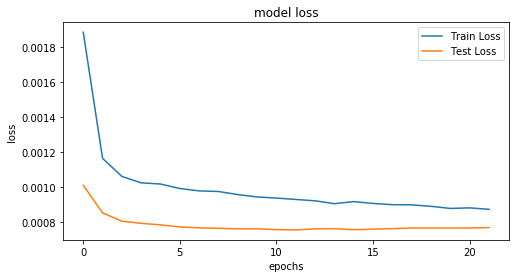

In [45]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

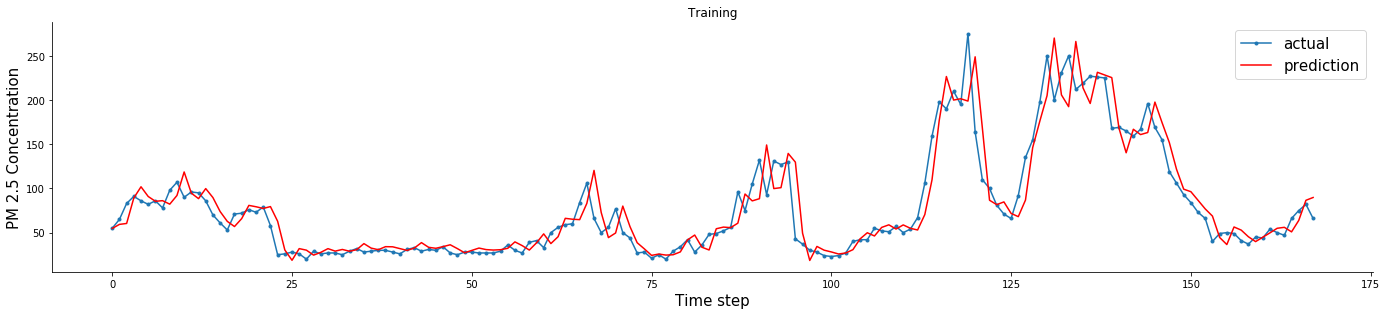

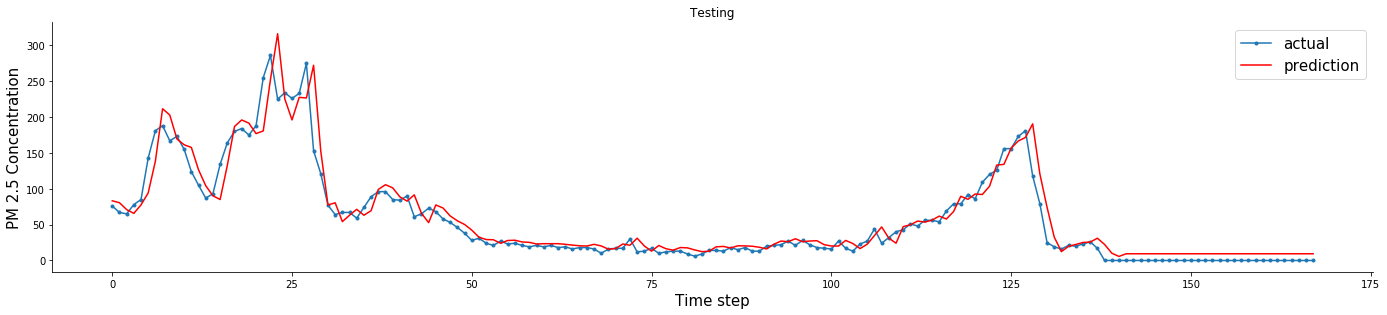

In [46]:
rng = 24*7 
aa = [x for x in range(rng)]

plt.figure(figsize=(20,4))
plt.plot(aa, data['train_out'][0][:rng], marker='.', label="actual")
plt.plot(aa, prediction['train_predict'][:,0][:rng], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Training')
plt.ylabel('PM 2.5 Concentration', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

plt.figure(figsize=(20,4))
plt.plot(aa, data['test_out'][0][:rng], marker='.', label="actual")
plt.plot(aa, prediction['test_predict'][:,0][:rng], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Testing')
plt.ylabel('PM 2.5 Concentration', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

#### 3.2.5 Modeling - CNN-LSTM

In [75]:
# CNN-LSTM

# split data into input and output
# choose a number of time steps
n_steps = 3
data['train_in'], data['train_out'] = split_sequence(data['train'], n_steps)
data['test_in'], data['test_out'] = split_sequence(data['test'], n_steps)

In [76]:
for key, val in data.items():
    print('{} => {}'.format(key, val.shape))

train => (8755, 1)
test => (35021, 1)
train_in => (8752, 3)
train_out => (8752,)
test_in => (35018, 3)
test_out => (35018,)


In [77]:
# reshape input menjadi 3D array : [samples, time steps, features]
data['train_in'] = np.reshape(data['train_in'], (data['train_in'].shape[0], data['train_in'] .shape[1], 1))
data['test_in']  = np.reshape(data['test_in'], (data['test_in'].shape[0], data['test_in'].shape[1], 1))

In [83]:
for key, val in data.items():
    print('{} => {}'.format(key, val.shape))

train => (8755, 1)
test => (35021, 1)
train_in => (8752, 3, 1)
train_out => (8752,)
test_in => (35018, 3, 1)
test_out => (35018,)


In [158]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(3, 1))))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100, stateful=True, return_sequences=True))
# model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [159]:
# train data and recorded in history
history = model.fit(data['train_in'], data['train_out'], epochs=50, batch_size=70, 
                    validation_data=(data['test_in'], data['test_out']), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

ValueError: input tensor must have rank 3